In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

In [2]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

In [3]:
# load the RPN-signature (trained on sample 1):
model_multi_center = joblib.load('../res/multi-center/finalized_model_multi-center.joblib') 

In [4]:
#get region names from an arbitrary timeseries file
ts = pd.read_csv('../data/bochum-sample/regional_timeseries/bochum-023_pumi-17-scrubbed.tsv').iloc[:,1:] 
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")

# function to extract predictive weights:
def get_weights(model, labels=labels, modules=modules):
    RES = np.zeros(int(len(labels)*(len(labels)-1)/2))

    featuremask = model.named_steps['fsel'].get_support()
    RES[featuremask] = model.named_steps['model'].coef_
    
    RES_MAT = vec_to_sym_matrix(RES, diagonal=np.repeat(0, len(labels)))
    return RES_MAT
    

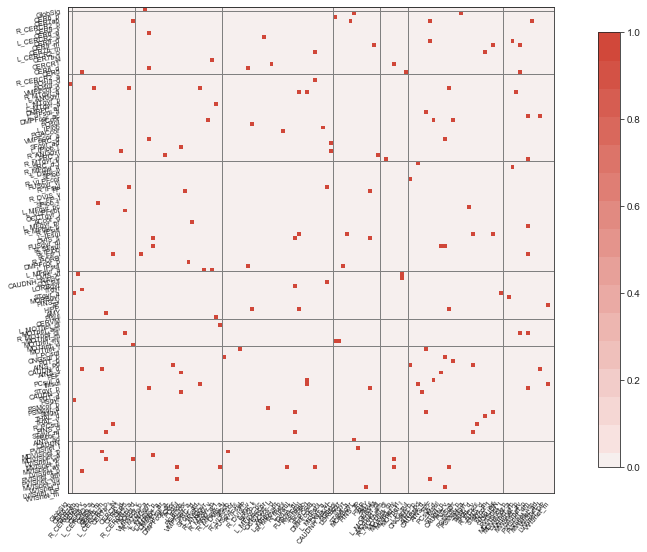

In [5]:
plot.plot_matrix(get_weights(model_multi_center)!=0, labels, modules)

In [6]:
rpn_conns = pd.read_csv("../res/predictive_connections.csv")
rpn_conns['abs_weight'] = rpn_conns['weight'].abs()
rpn_conns = rpn_conns.sort_values('abs_weight', ascending=False)
rpn_conns = rpn_conns.reset_index()
rpn_conns

,index,Unnamed: 0,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight
0,15,15,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232
1,5,5,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274
2,1,1,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617
3,7,7,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634
4,14,14,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468
5,20,20,121,122,8_VISnet,8_VISnet,LVISnet_DP,VVISnet_m,0.094911,0.094911
6,0,0,0,34,2_MEAN_GM,7_DMnet,aMEAN_GM,L_IPlob,-0.086423,0.086423
7,18,18,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078
8,12,12,67,118,4_LIMnet,8_VISnet,CAUDNH_NACC,PVISnet_vm,-0.072571,0.072571
9,13,13,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491


In [7]:
#create a similar table from the multi-center signsature
RES_MAT = get_weights(model_multi_center)

df = pd.DataFrame(RES_MAT, columns=labels, index=labels)

idx = np.transpose(np.nonzero(np.triu(RES_MAT, k=1)))
print("Number of predictive connections:" + str(len(idx)))

lab = labels
#mod = modules
# hack for visulaization order
mod = np.array(['2_MEAN_GM',
'1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER',
 '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '4_LIMnet', '4_LIMnet', '4_LIMnet',
 '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet',
 '4_LIMnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL', '8_VISnet', '8_VISnet',
 '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet',
 '8_VISnet', '8_VISnet', '8_VISnet'])

#hack: rename for visualization order

multi_center_conns = pd.DataFrame( {'idx_A': idx[:,0],
                   'reg_A': lab[np.array(idx[:,0])],
                   'mod_A': mod[np.array(idx[:,0])],
                   'idx_B': idx[:,1],
                   'reg_B': lab[np.array(idx[:,1])],
                   'mod_B': mod[np.array(idx[:,1])],
                   'multi-center': RES_MAT[np.nonzero(np.triu(RES_MAT, k=1))].flatten()})


#table.to_csv(global_vars._RES_PRED_CONN_)
multi_center_conns['abs_multi-center'] = multi_center_conns['multi-center'].abs()
#table = table.sort_values('abs_multi-center', ascending=False)
#table = table.reset_index()
multi_center_conns

Number of predictive connections:80


,idx_A,reg_A,mod_A,idx_B,reg_B,mod_B,multi-center,abs_multi-center
0,0,GlobSig,2_MEAN_GM,19,VMPFcor_p,7_DMnet,0.070111,0.070111
1,1,CER6_p,1_CER,72,MORBgyr,4_LIMnet,0.026635,0.026635
2,1,CER6_p,1_CER,99,PSMcor_p,3_VATTnet_SALnet_BG_THAL,-0.085299,0.085299
3,2,CER7ab,1_CER,67,CAUDNH_NACC,4_LIMnet,0.030211,0.030211
4,3,R_CERCR2_p,1_CER,16,R_CERCR2_a,1_CER,0.022169,0.022169
...,...,...,...,...,...,...,...,...
75,92,FEF,3_VATTnet_SALnet_BG_THAL,94,IMsul,3_VATTnet_SALnet_BG_THAL,0.015347,0.015347
76,95,STgyr_p,3_VATTnet_SALnet_BG_THAL,121,LVISnet_DP,8_VISnet,0.010651,0.010651
77,96,CAUDN_v,3_VATTnet_SALnet_BG_THAL,116,LVISnet_p,8_VISnet,0.007283,0.007283
78,102,THAL_d,3_VATTnet_SALnet_BG_THAL,107,PCcor.1,3_VATTnet_SALnet_BG_THAL,0.025226,0.025226


In [8]:
rpn_conns['single-study']=rpn_conns['weight']
rpn_conns['connectivity'] = rpn_conns.reg_A.str.cat(' - ' + rpn_conns.reg_B).values
#rpn_conns = rpn_conns.set_index('connectivity', drop=)


multi_center_conns['connectivity'] = multi_center_conns.reg_A.str.cat(' - ' + multi_center_conns.reg_B).values
#table = table.set_index('connectivity', drop=False)

allconns=rpn_conns.merge(multi_center_conns, how='outer').iloc[:, 2:]
rpnonly=allconns[~allconns.weight.isna()].copy()

rpnonly['connectivity'] = rpnonly.reg_A.str.cat(' - ' + rpnonly.reg_B).values
rpnonly['abs_multi-center'] = rpnonly['multi-center'].abs()
rpnonly = rpnonly.sort_values('abs_multi-center', ascending=False)
rpnonly = rpnonly.reset_index()

#pd.wide_to_long(rpnonly[['connectivity', 'wrpn', 'wmulticenter']], "w", i="connectivity", j='model')
rpnonly_melt = pd.melt(rpnonly[['connectivity', 'single-study', 'multi-center']], id_vars=['connectivity'],
                       value_vars=['single-study', 'multi-center'], var_name='model')
rpnonly_melt       


,connectivity,model,value
0,R_CERCR2_a - MOTnet_l,single-study,0.149634
1,CER6_p - PSMcor_p,single-study,-0.200617
2,AINS_v - MVISnet_ad,single-study,-0.044237
3,CER6_d - OCCTgyr_l,single-study,-0.056635
4,COLsul - MOTnet_vl,single-study,-0.062491
5,CER5 - FP,single-study,0.245274
6,R_IPsul - LVISnet_p,single-study,-0.053913
7,PUT_p - STgyr_p,single-study,0.270232
8,CAUDN_v - LVISnet_p,single-study,0.085078
9,MOTnet_m - MVISnet_p,single-study,-0.102468


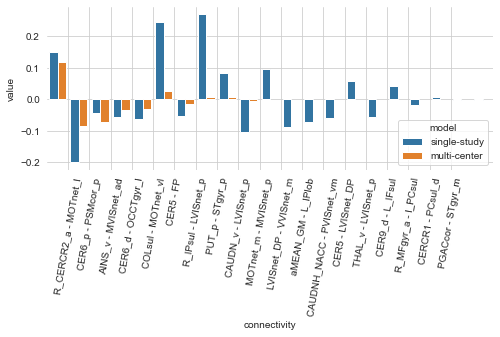

In [91]:
colors = ["tab:blue", "tab:orange"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(8, 3))
sns.barplot(data=rpnonly_melt, x='connectivity', y='value', hue='model')
plt.xticks(rotation=80)
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.xticks([x-0.5 for x in range(1,20, 1)] )
plt.savefig('../res/multi-center/barplot.pdf')  

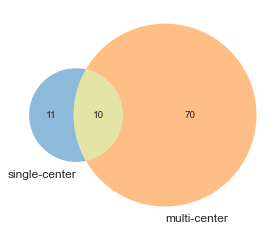

In [93]:
from matplotlib_venn import venn2

n_rpn = len(rpn_conns)
n_mc = len(multi_center_conns)
n_intersection = len(rpnonly.dropna())

# Use the venn2 function
v=venn2(subsets = (n_rpn - n_intersection,
                 n_mc - n_intersection,
                 n_intersection), set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_conns.pdf')  

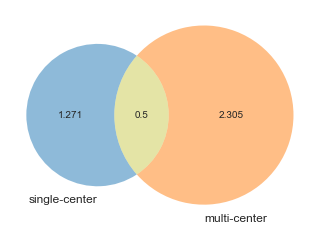

In [94]:
from matplotlib_venn import venn2

w_rpn = rpnonly['single-study'].abs().sum()
w_mc = multi_center_conns['multi-center'].abs().sum()
w_intersection = w_rpn - rpnonly.dropna()['single-study'].abs().sum()

# Use the venn2 function
v=venn2(subsets = (np.round(w_rpn - w_intersection, 3),
                 np.round(w_mc - w_intersection, 3),
                 np.round(w_intersection, 3)
                 ),
      set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_weights.pdf')  

True


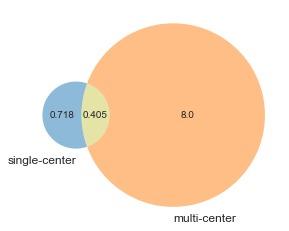

In [95]:
from matplotlib_venn import venn2

w_rpn = rpnonly['single-study'].abs().sum()
w_mc = multi_center_conns['multi-center'].abs().sum() 
w_intersection_rpn = rpnonly.dropna()['single-study'].abs().sum() / w_rpn
w_intersection_mc = rpnonly.dropna()['multi-center'].abs().sum() / w_mc
w_mc_norm = w_intersection_rpn * w_mc / w_intersection_mc

print(w_intersection_mc / w_mc == w_intersection_rpn / w_mc_norm)

# Use the venn2 function
v=venn2(subsets = (np.round((w_rpn - w_intersection) / w_rpn, 3),
                 np.round((w_mc_norm - w_intersection_rpn) / w_rpn, 0),
                 np.round(w_intersection_rpn / w_rpn, 3)
                 ),
      set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_weights.pdf')  

In [41]:
w_intersection_mc / w_mc == w_intersection_rpn / w_mc_norm

0.4054821465444012

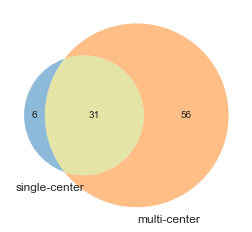

In [96]:
regs_rpn = len(np.unique(np.hstack((rpn_conns.reg_A.values, rpn_conns.reg_B.values)) )) # 37/122
regs_mc = len(np.unique(np.hstack((multi_center_conns.reg_A.values, multi_center_conns.reg_B.values)) )) #87/122
regs_union = len(np.unique(np.hstack((rpn_conns.reg_A.values, rpn_conns.reg_B.values,
           multi_center_conns.reg_A.values, multi_center_conns.reg_B.values)) ))
regs_intersection = regs_rpn + regs_mc - regs_union

v=venn2(subsets = (regs_rpn-regs_intersection,
                 regs_mc-regs_intersection,
                 regs_intersection
                 ),
      set_labels = ('single-center', 'multi-center'))
v.get_patch_by_id('10').set_color('tab:blue')
v.get_patch_by_id('01').set_color('tab:orange')
v.get_patch_by_id('11').set_color('tab:olive')
v.get_patch_by_id('10').set_edgecolor('none')
v.get_patch_by_id('01').set_edgecolor('none')
v.get_patch_by_id('11').set_edgecolor('none')
v.get_patch_by_id('10').set_alpha(0.5)
v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/venn_num_regions.pdf')  

In [53]:
# chord diagram

module_names = np.unique(mod)
# creeate modular matrix:
rpn_matrix_pos = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)
rpn_matrix_neg = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)



for i in range(len(rpn_conns)):
    if rpn_conns.weight[i] > 0:
        rpn_matrix_pos.loc[rpn_conns.mod_A[i], rpn_conns.mod_B[i]] += rpn_conns.weight[i]
        rpn_matrix_pos.loc[rpn_conns.mod_B[i], rpn_conns.mod_A[i]] += rpn_conns.weight[i]
    if rpn_conns.weight[i] < 0:
        rpn_matrix_neg.loc[rpn_conns.mod_A[i], rpn_conns.mod_B[i]] += rpn_conns.weight[i]
        rpn_matrix_neg.loc[rpn_conns.mod_B[i], rpn_conns.mod_A[i]] += rpn_conns.weight[i]



In [54]:
# chord diagram

module_names = np.unique(mod)
# creeate modular matrix:
mc_matrix_pos = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)
mc_matrix_neg = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)



for i in range(len(multi_center_conns)):
    if multi_center_conns['multi-center'][i] > 0:
        mc_matrix_pos.loc[multi_center_conns.mod_A[i], multi_center_conns.mod_B[i]] += multi_center_conns['multi-center'][i]
        mc_matrix_pos.loc[multi_center_conns.mod_B[i], multi_center_conns.mod_A[i]] += multi_center_conns['multi-center'][i]

    if multi_center_conns['multi-center'][i] < 0:
        mc_matrix_neg.loc[multi_center_conns.mod_A[i], multi_center_conns.mod_B[i]] += multi_center_conns['multi-center'][i]
        mc_matrix_neg.loc[multi_center_conns.mod_B[i], multi_center_conns.mod_A[i]] += multi_center_conns['multi-center'][i]
        
        

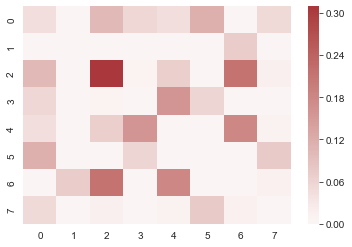

In [89]:
sns.heatmap(mc_matrix_pos.values, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_mc_pos.pdf')  

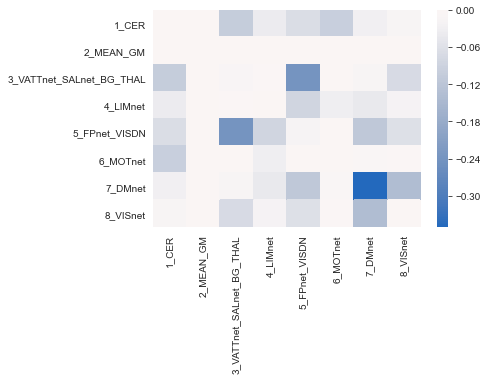

In [86]:
sns.heatmap(mc_matrix_neg, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_mc_neg.pdf')  

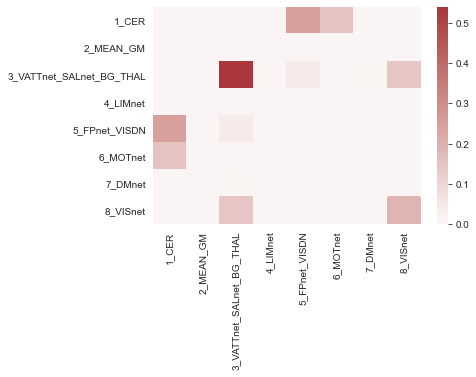

In [87]:
sns.heatmap(rpn_matrix_pos, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_rpn_pos.pdf')  

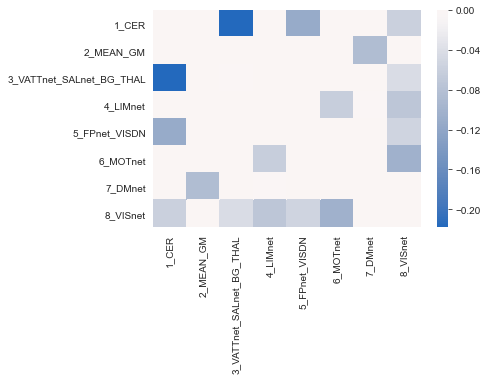

In [88]:
sns.heatmap(rpn_matrix_neg, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_rpn_neg.pdf')  

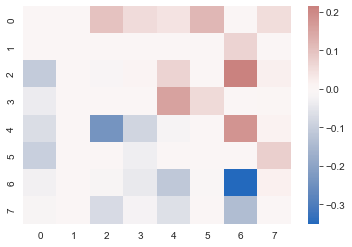

In [98]:
sns.heatmap(matrix, cmap="vlag", center=0)
plt.savefig('../res/multi-center/palette.pdf')  

In [100]:
pd.set_option("display.max_rows", None)
multi_center_conns

,idx_A,reg_A,mod_A,idx_B,reg_B,mod_B,multi-center,abs_multi-center,connectivity
0,0,GlobSig,2_MEAN_GM,19,VMPFcor_p,7_DMnet,0.070111,0.070111,GlobSig - VMPFcor_p
1,1,CER6_p,1_CER,72,MORBgyr,4_LIMnet,0.026635,0.026635,CER6_p - MORBgyr
2,1,CER6_p,1_CER,99,PSMcor_p,3_VATTnet_SALnet_BG_THAL,-0.085299,0.085299,CER6_p - PSMcor_p
3,2,CER7ab,1_CER,67,CAUDNH_NACC,4_LIMnet,0.030211,0.030211,CER7ab - CAUDNH_NACC
4,3,R_CERCR2_p,1_CER,16,R_CERCR2_a,1_CER,0.022169,0.022169,R_CERCR2_p - R_CERCR2_a
5,3,R_CERCR2_p,1_CER,71,STgyr_a,4_LIMnet,-0.034228,0.034228,R_CERCR2_p - STgyr_a
6,3,R_CERCR2_p,1_CER,91,AINS_v,3_VATTnet_SALnet_BG_THAL,-0.012958,0.012958,R_CERCR2_p - AINS_v
7,3,R_CERCR2_p,1_CER,117,PVISnet_dm,8_VISnet,0.015319,0.015319,R_CERCR2_p - PVISnet_dm
8,6,L_CERCR2_a,1_CER,20,R_MTgyr_a,7_DMnet,-0.002248,0.002248,L_CERCR2_a - R_MTgyr_a
9,7,CER9_d,1_CER,49,L_MFgyr_pc,5_FPnet_VISDN,0.017140,0.017140,CER9_d - L_MFgyr_pc


In [101]:
allconns

,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight,single-study,connectivity,multi-center,abs_multi-center
0,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232,0.270232,PUT_p - STgyr_p,0.008273,0.008273
1,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274,0.245274,CER5 - FP,0.026394,0.026394
2,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617,-0.200617,CER6_p - PSMcor_p,-0.085299,0.085299
3,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634,0.149634,R_CERCR2_a - MOTnet_l,0.117064,0.117064
4,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468,-0.102468,MOTnet_m - MVISnet_p,-0.004270,0.004270
5,121,122,8_VISnet,8_VISnet,LVISnet_DP,VVISnet_m,0.094911,0.094911,0.094911,LVISnet_DP - VVISnet_m,NaN,NaN
6,0,34,2_MEAN_GM,7_DMnet,aMEAN_GM,L_IPlob,-0.086423,0.086423,-0.086423,aMEAN_GM - L_IPlob,NaN,NaN
7,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078,0.085078,CAUDN_v - LVISnet_p,0.007283,0.007283
8,67,118,4_LIMnet,8_VISnet,CAUDNH_NACC,PVISnet_vm,-0.072571,0.072571,-0.072571,CAUDNH_NACC - PVISnet_vm,NaN,NaN
9,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491,-0.062491,COLsul - MOTnet_vl,-0.031813,0.031813
